# Encoding combined model results

In [2]:
%%bash

. ~/.bashrc
module load fsl

cd /u/project/monti/Analysis/Analogy/analysis/group/encoding

mkdir vis
fslmaths ab-mainrel-kfold-elasticnet-lambda1/n1000-ab_BARTnorm_cv-relation_tfce_corrp_tstat1.nii.gz \
    -thr .95 -bin vis/ab-BARTnorm_1
    
fslmaths ab-mainrel-kfold-elasticnet-lambda1/n1000-ab_BART_cv-relation_tfce_corrp_tstat1.nii.gz \
    -thr .95 vis/ab-BART_thr95
    
fslmaths cd-mapping/n1000-CDMatch_rstpostprob79_tfce_corrp_tstat1.nii.gz \
    -thr .95 -bin -mul 2 vis/cd-BART_2

fslmaths vis/ab-BARTnorm_1 -add vis/cd-BART_2 vis/encoding-result

mkdir: cannot create directory `vis': File exists


In [1]:
%%bash

. ~/.bashrc
module load fsl

cd /u/project/monti/Analysis/Analogy/analysis/group/encoding

mkdir vis
    
fslmaths ab-mainrel-kfold-elasticnet-lambda1/n5000-ab_BART_cv-relation_tfce_p_tstat1.nii.gz \
    -thr .95 vis/ab-BART_uncorrp_thr95

fslmaths ab-mainrel-kfold-elasticnet-lambda1/n5000-ab_BART_cv-relation_tfce_corrp_tstat1.nii.gz \
    -mas vis/ab-BART_uncorrp_thr95 vis/ab-BART_corrp_masked_uncorrp



mkdir: cannot create directory `vis': File exists


In [5]:
%%bash

. ~/.bashrc
module load fsl

cd /u/project/monti/Analysis/Analogy/analysis/group/multivariate/rsa/pearson

mkdir vis
fslmaths n1000-AB_BART79_tfce_corrp_tstat1 -thr .95 -bin sig_mask
fslmaths  n1000-AB_BART79-accuracy_tfce_corrp_tstat1 \
    -mul sig_mask \
    -thr .95 -bin -mul 2 vis/bart-acc_2

fslmaths  n1000-AB_BART79-baseline_tfce_corrp_tstat1 \
    -mul sig_mask \
    -thr .95 -bin vis/bart-base

fslmaths vis/bart-base -add vis/bart-acc_2 vis/bart-vs-other_2

rm sig_mask

fslmaths n1000-AB_BART79_vox_fdrp_tstat1 -thr .95 -bin sig_mask
fslmaths  n1000-AB_BART79-accuracy_vox_fdrp_tstat1 \
    -mul sig_mask \
    -thr .95 -bin -mul 2 vis/bart-acc_2

fslmaths  n1000-AB_BART79-baseline_tfce_corrp_tstat1 \
    -mul sig_mask \
    -thr .95 -bin vis/bart-base

rm sig_mask

fslmaths vis/bart-base -add vis/bart-acc_2 vis/bart-vs-other_2

mkdir: cannot create directory `vis': File exists


# Model correlations

/u/home/n/njchiang/.conda/envs/fmri/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Loading JSON config from config/analyses.json
Loading JSON config from config/contrasts.json
Loading label file from: labels/trialorder_rsa_absorted.csv
Loading label file from: /u/project/monti/Analysis/Analogy/code/analogy-fmri/labels/raw_models.csv


[Text(0, 1, ''),
 Text(0, 1, 'Baseline'),
 Text(0, 1, 'Word2vec-diff'),
 Text(0, 1, 'Word2vec-concat'),
 Text(0, 1, 'BART'),
 Text(0, 1, 'BART-thresh'),
 Text(0, 1, 'Accuracy')]

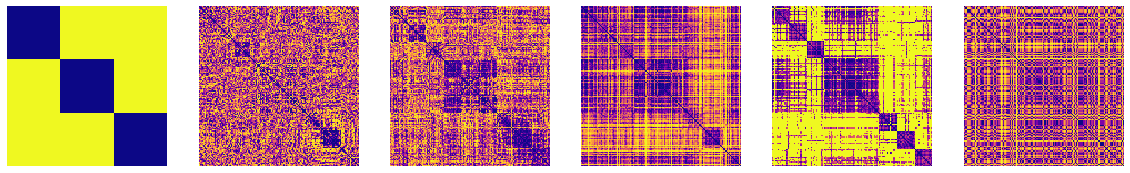

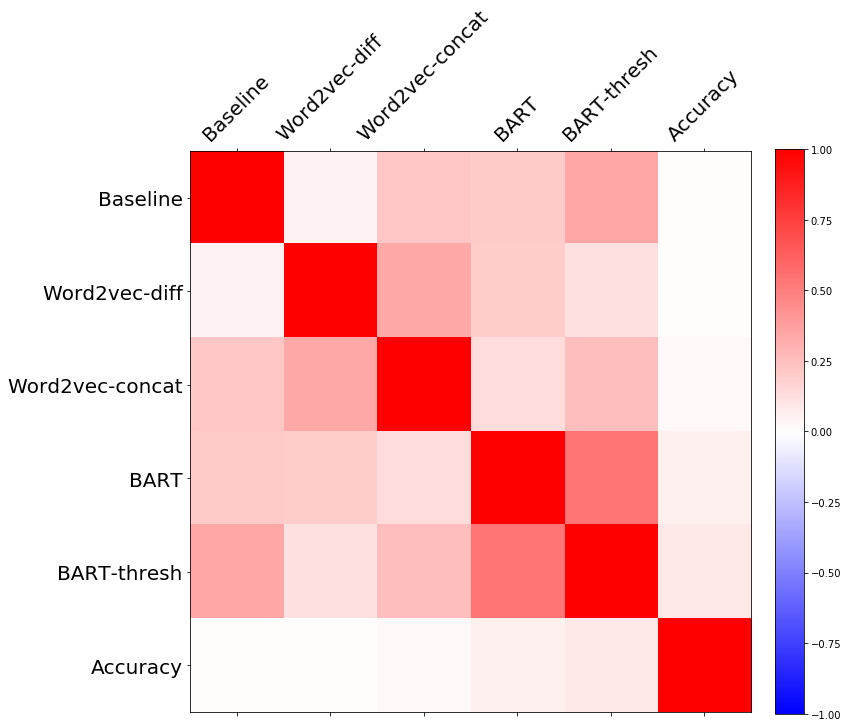

In [1]:
import json
import sys
import os
os.chdir("..")
from datetime import datetime
# import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from analysis.fmri.analogy_utils import analysisSettings, contrastSettings, projectSettings, \
    PATHS, order, \
    pu, pa, pv, rsa, \
    compile_models, save_rois, load_rois, load_betas

from analysis.fmri.analogy_rsa import get_model_rdms

paths = PATHS

%matplotlib inline
import matplotlib.pyplot as plt
# model_figure
# plotmodels_old(models, save=False)

modelnames = ["mainrel", "w2vdiff", "concatword", "rstpostprob79", "bart79thresh", "accuracy"]

raw_vis_models_df = pu.load_labels(os.path.join(paths["code"], "labels", "raw_models.csv"))
vis_model_rdms = get_model_rdms(raw_vis_models_df, modelnames)
# .sort_values("MainCond", "ABTag")


f = plt.figure(figsize=(20,10))
axarr = f.subplots(1, len(vis_model_rdms.name.unique()))
rdms = vis_model_rdms[vis_model_rdms.type == "avg"]
for j, m in enumerate(vis_model_rdms.name.unique()):
    pv.plot_rdm(rdms[rdms.name==m].iloc[:, 2:].dropna(axis=1),
           ax=axarr[j], cb=False, cmap="plasma")
#     axarr[j].set_title(m)
    axarr[j].set_axis_off()
    
    
    
# Relationship between the models
model_rdms = vis_model_rdms
modelnames = ["", "Baseline", "Word2vec-diff", "Word2vec-concat", "BART", "BART-thresh", "Accuracy"]

f = plt.figure(figsize=(11, 11))
ax = f.gca()
# f, axarr = plt.subplots(1,3, figsize=(11, 8.5))
im = ax.matshow(
        model_rdms[model_rdms.type == "avg"].dropna(axis=1).iloc[:, 2:].T.corr(method="spearman"), 
    vmin=-1, vmax=1, cmap="bwr")
f.colorbar(im, fraction=0.046, pad=0.04)
# ax.set_xticks(range(len(modelnames)))
# ax.set_yticks(range(len(modelnames)))
ax.set_yticklabels(modelnames, fontsize=20)
ax.set_xticklabels(modelnames, rotation=45, fontsize=20)
